# Volume 3: K-Means Clustering.
    <Name>
    <Class>
    <Date>

In [22]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

In [23]:
plt.rcParams["figure.dpi"] = 200

In [30]:
class KMeans:
    """Basic k-means clustering class."""
    def __init__(self, n_clusters=8, max_iter=100, tol=1e-5, normalize=False, p=2):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.normalize = normalize
        self.p = p
    
    def fit(self, X, y=None):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        self.centers = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for _ in range(self.max_iter):
            # Compute the distance from each point to each center.
            distances = np.linalg.norm(X[:, None] - self.centers, axis=2, ord=self.p)
            # Find the index of the closest center to each point.
            labels = np.argmin(distances, axis=1)
            # Update the cluster centers.
            new_centers = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            
            # Checking to see if a cluser is empty, if so, reinitialize that cluster center
            for i in range(self.n_clusters):
                if len(X[labels == i]) == 0:
                    new_centers[i] = X[np.random.choice(X.shape[0], 1, replace=False)]
            
            # Normalize the cluster centers if normalize is True
            if self.normalize:
                new_centers = new_centers / np.linalg.norm(new_centers, axis=1)[:, None]

            # Check for convergence.
            if np.linalg.norm(new_centers - self.centers) < self.tol:
                break

            # Saving the cluster centers as attributes
            self.centers = new_centers

    
    def predict(self, X):
        """Classify each entry of X based on which cluster center it belongs to.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        
        Returns:
            ((n_samples) ndarray): Integer labels from 0 to n_clusters for each entry of X.
        """
        distances = np.linalg.norm(X[:, None] - self.centers, axis=2, ord=self.p)
        return np.argmin(distances, axis=1)
    
    def fit_predict(self, X):
        """Fit to the data and return the resulting labels.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        return self.fit(X).predict(X)
    
    def plot(self, X, y):
        """Plot each of the data points, colored by cluster.
        Plot each of the cluster centers using a different marker.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data being clustered.
            y ((n_samples) ndarray): the labels for each of the samples.
        """
        # Using y as the labels for the data points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
        # Plotting the cluster centers
        plt.scatter(self.centers[:, 0], self.centers[:, 1], c='black', marker='x')
        plt.show()


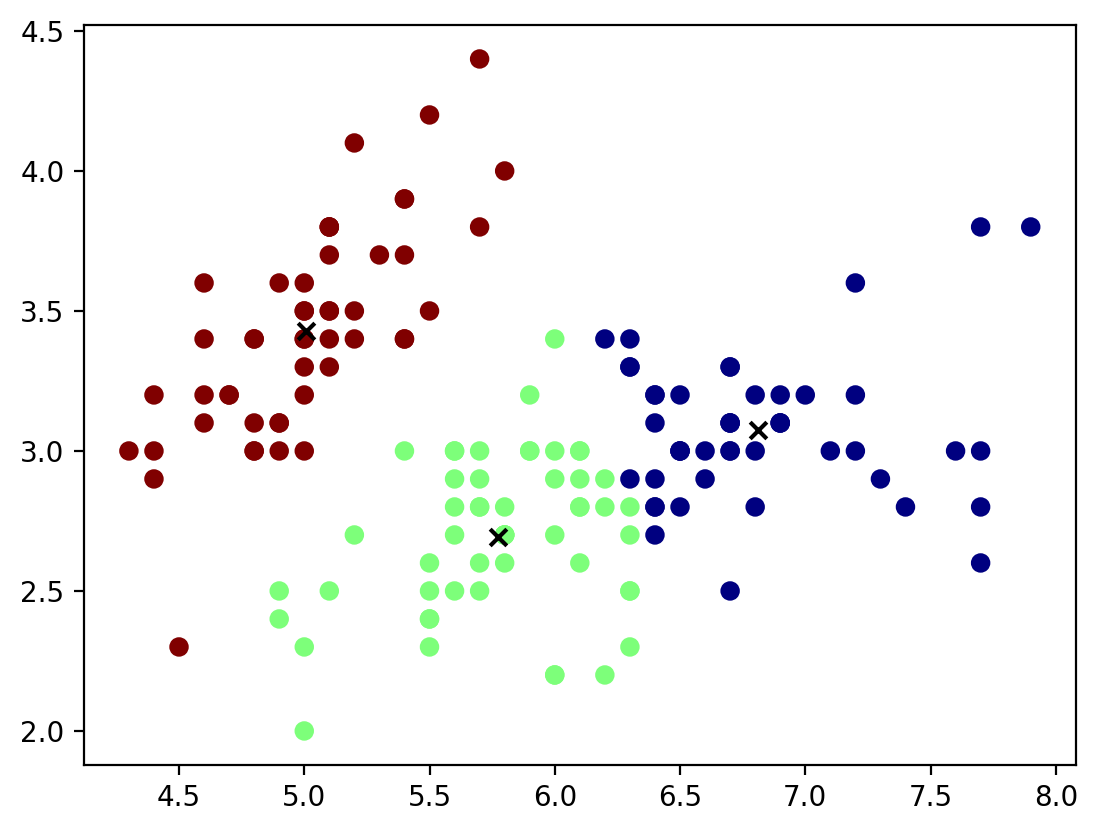

In [31]:
# Testing Problem 1 with the Iris dataset
iris = load_iris()

# Using the first two features for simplicity
X = iris.data[:, :2]

# Testing the fit method
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y = kmeans.predict(X)
kmeans.plot(X, y)


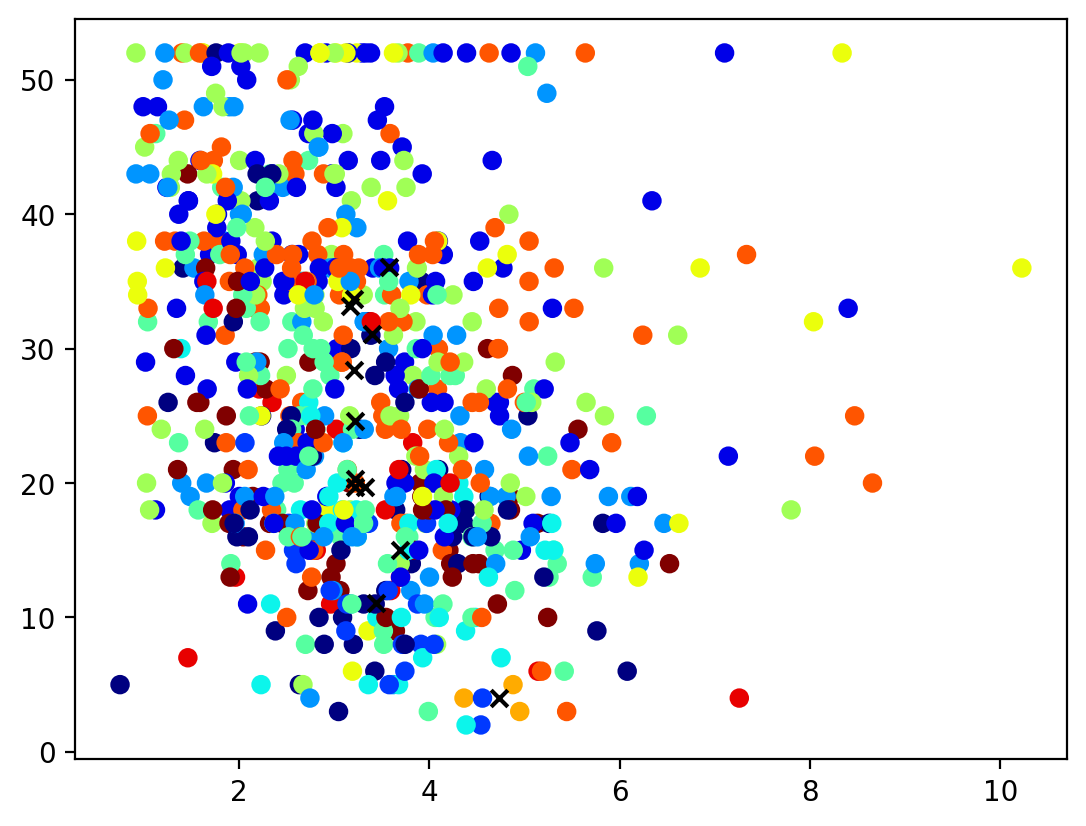

Average distance to furthest point: 14025.695877914977


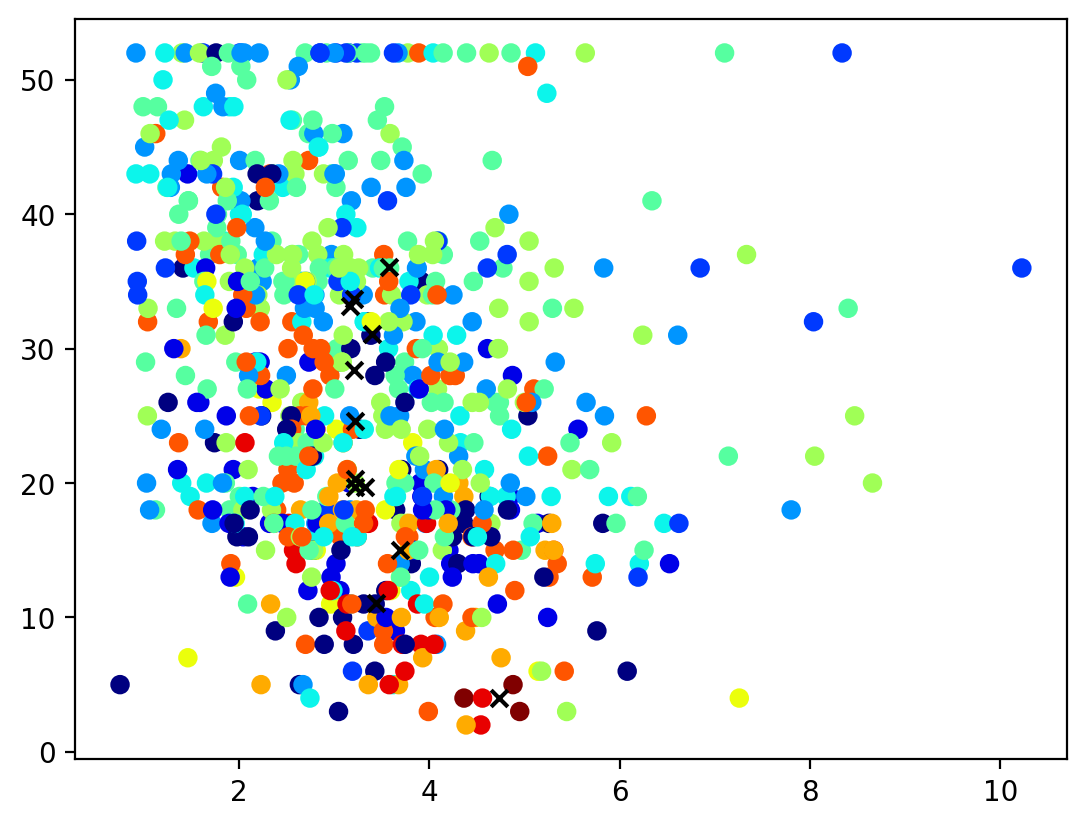

Average distance to furthest point: 13998.450820615288


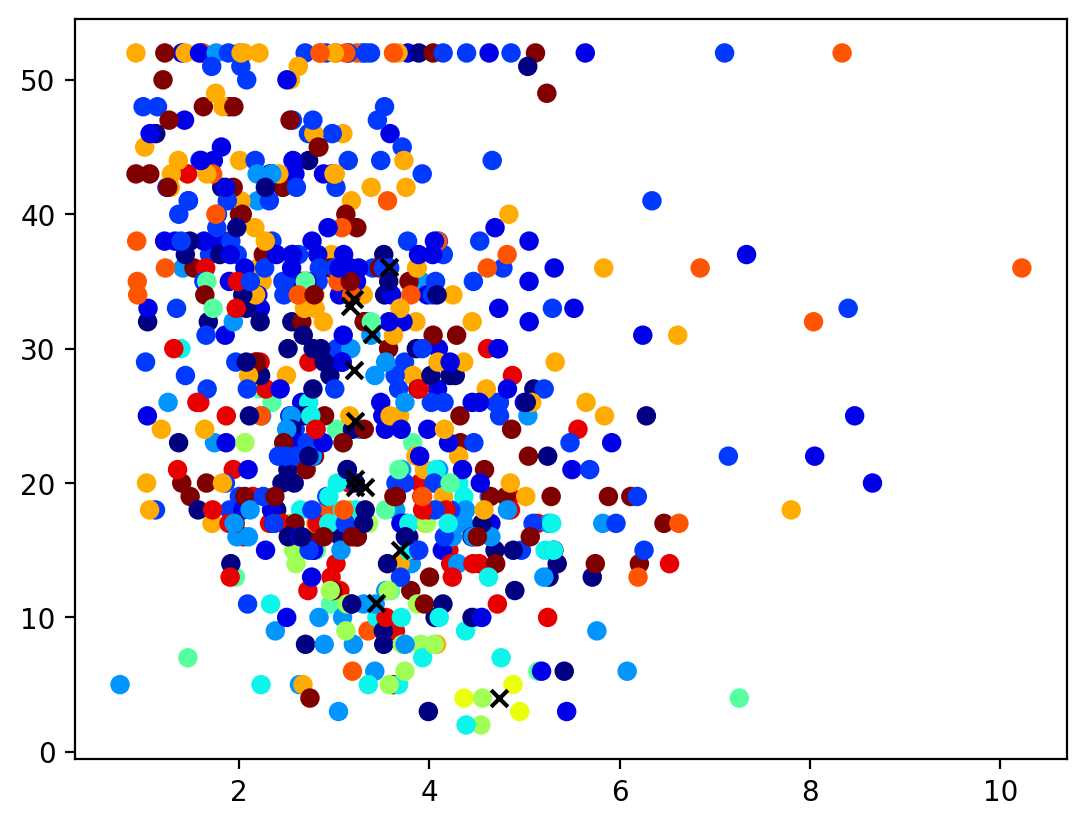

Average distance to furthest point: 13998.430682704935


In [26]:
# Loading the sacramento.npy dataset
data = np.load('./Data/sacramento.npy')

# Each row is a longitude, latitude pair for a house in Sacramento.
# Selecting 3 possible norms. We'll test which minimizes the distance to the furthest point / house.
p_values = [1, 2, np.inf]
for p in p_values:
    kmeans = KMeans(n_clusters=12, p=p)
    kmeans.fit(data)
    y = kmeans.predict(data)
    kmeans.plot(data, y)

    # Calculating the distance to the furthest point for each cluster and the points in that cluster
    distances = np.linalg.norm(data[:, None] - kmeans.centers, axis=2, ord=p)
    max_distances = np.max(distances, axis=0)
    print(f"Average distance to furthest point: {np.mean(max_distances)}")

# The p=2 norm minimizes the distance to the furthest point / house.

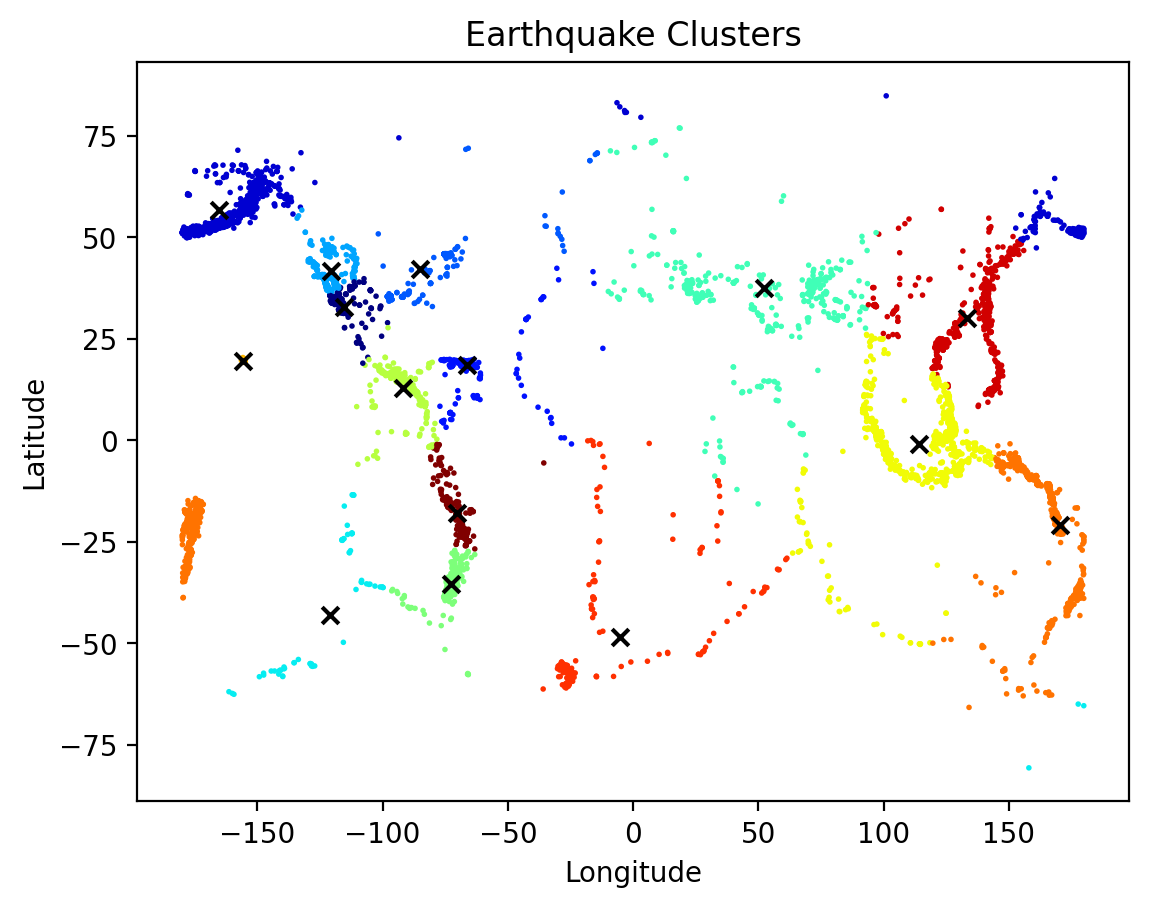

In [27]:
# Loading the earthquake_coordinates.npy dataset. The first column is the longitude and the second column is the latitude.
data = np.load('./Data/earthquake_coordinates.npy')
data2 = data.copy()

# Converting the data to spherical coordinates
# First column will be theta and the second column will be phi
data[:, 0] = data[:, 0] * np.pi / 180
data[:, 1] = (90 - data[:, 1]) * np.pi / 180

# Creating a new np array with the euclidean coordinates created from the spherical coordinates
X = np.zeros((data.shape[0], 3))
X[:, 0] = np.sin(data[:, 1]) * np.cos(data[:, 0])
X[:, 1] = np.sin(data[:, 1]) * np.sin(data[:, 0])
X[:, 2] = np.cos(data[:, 1])

# Now that we have spherical coordinates, we can use the KMeans algorithm to cluster the earthquakes with K = 15
kmeans = KMeans(n_clusters=15, p=2, normalize=True)
kmeans.fit(X)
y = kmeans.predict(X)

# Translating the cluster centers back to spherical coordinates
centers = kmeans.centers
theta = np.arctan2(centers[:, 1], centers[:, 0]) # This is the longitude
phi = np.arccos(centers[:, 2])
centers[:, 0] = theta
centers[:, 1] = phi

# Converting to longitude and latitude again
centers[:, 0] = centers[:, 0] * 180 / np.pi
centers[:, 1] = 90 - centers[:, 1] * 180 / np.pi

# Plotting the earthquakes and the cluster centers
plt.scatter(data2[:, 0], data2[:, 1], c=y, cmap='jet', s=1)
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquake Clusters')
plt.show()


In [28]:
def quantize_image(im, n_clusters=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    # Choosing n_samples random pixels from the image
    np.random.seed(0)
    m, n, _ = im.shape
    X = im.reshape(-1, 3)
    idx = np.random.choice(X.shape[0], n_samples, replace=False)
    Y = X[idx]

    # Fitting the sklearn.cluster.KMeans model to the data
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(Y)
    y = kmeans.predict(X)

    # Replacing each pixel with the color of its cluster center
    centers = kmeans.centers
    quantized_im = centers[y].reshape(m, n, 3)

    # Scaling the image back to 0-255
    quantized_im = np.clip(quantized_im, 0, 255).astype(np.uint8)
    return quantized_im


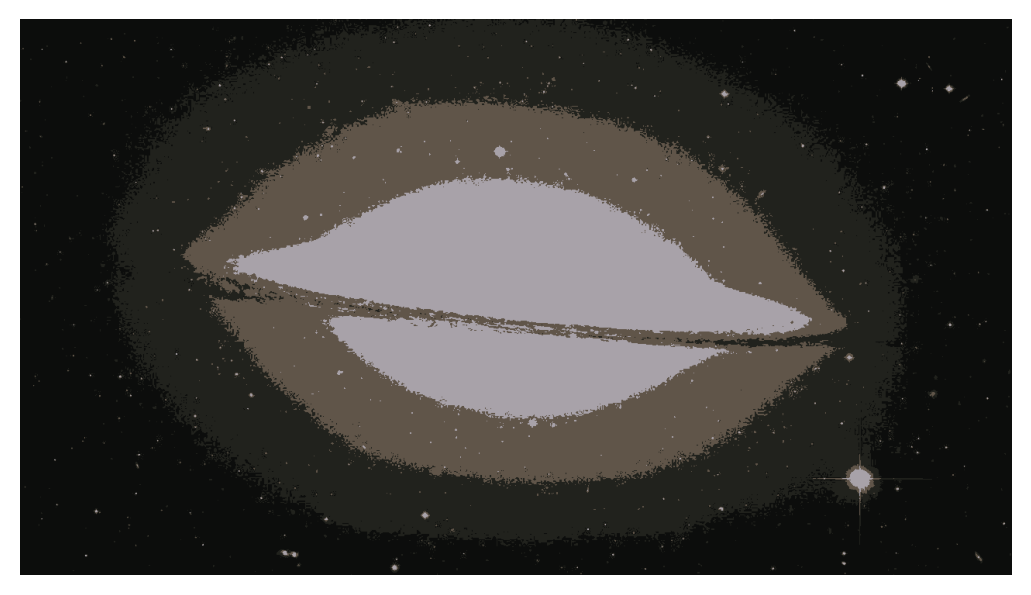

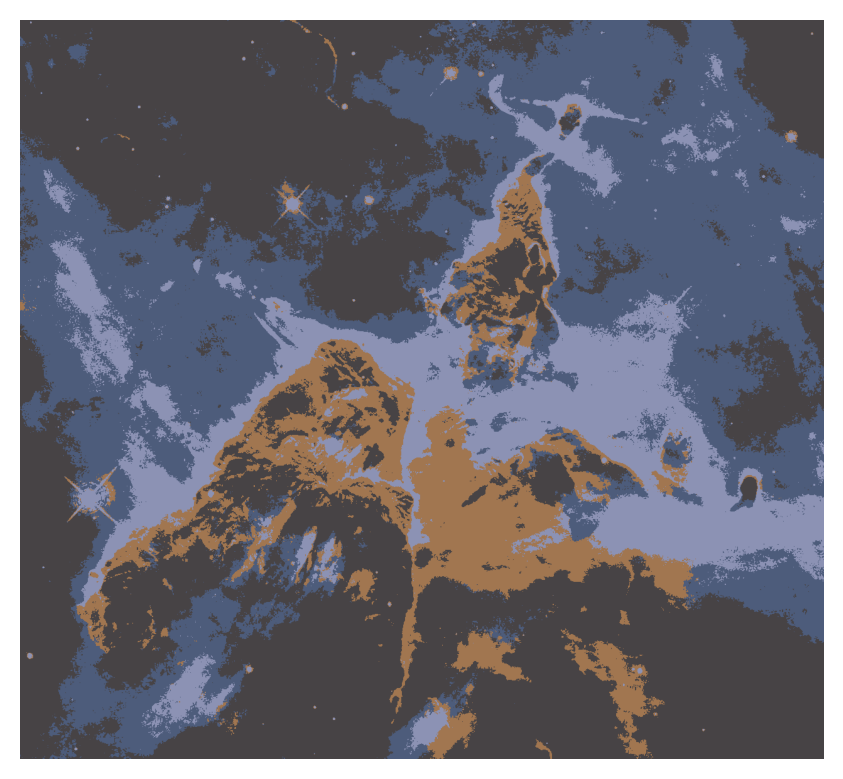

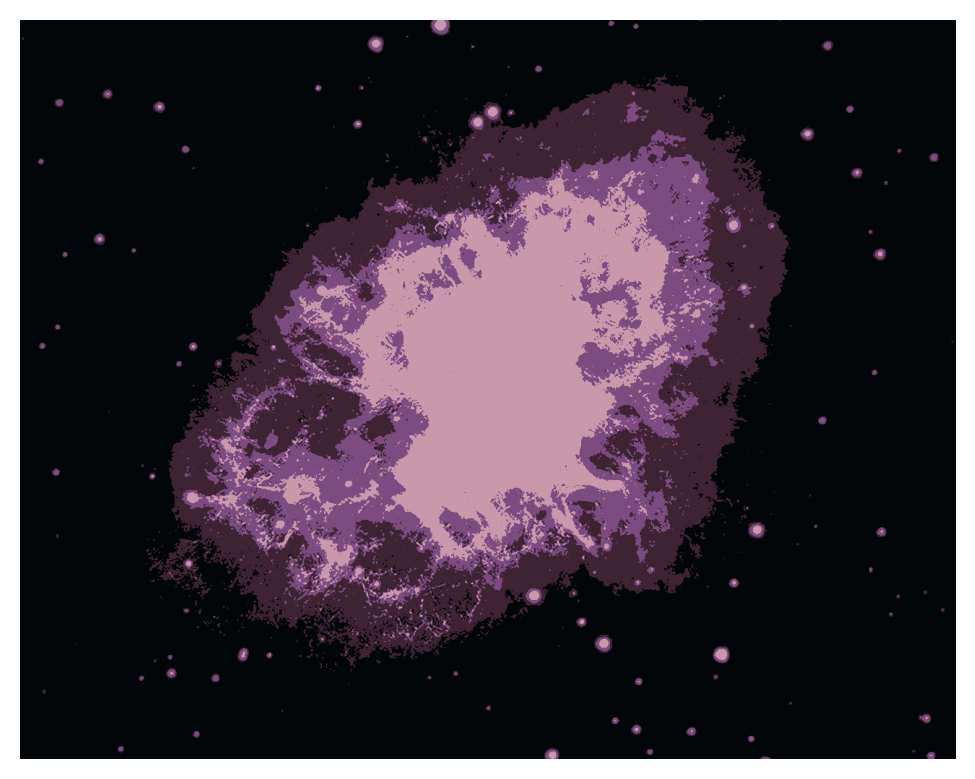

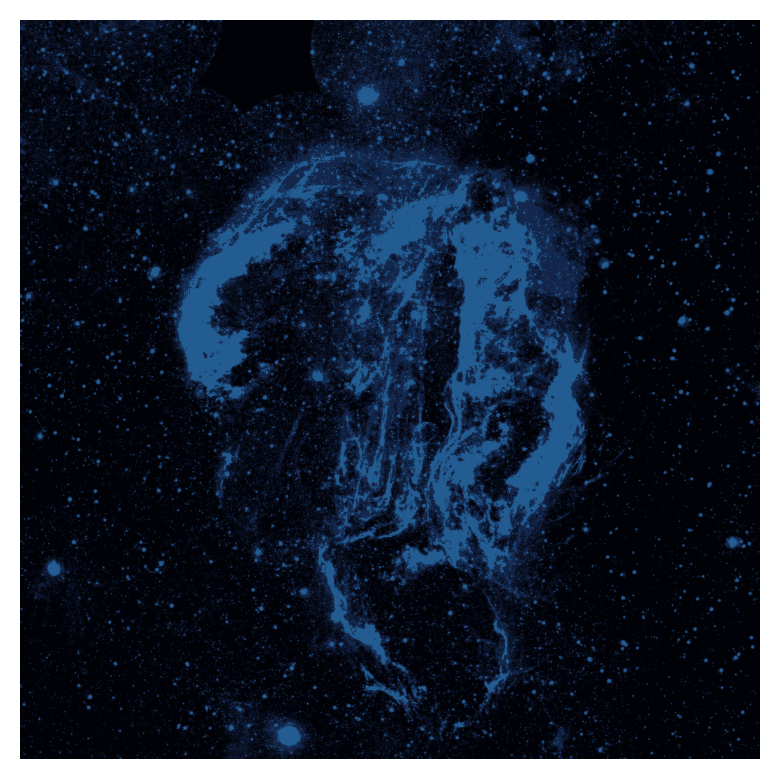

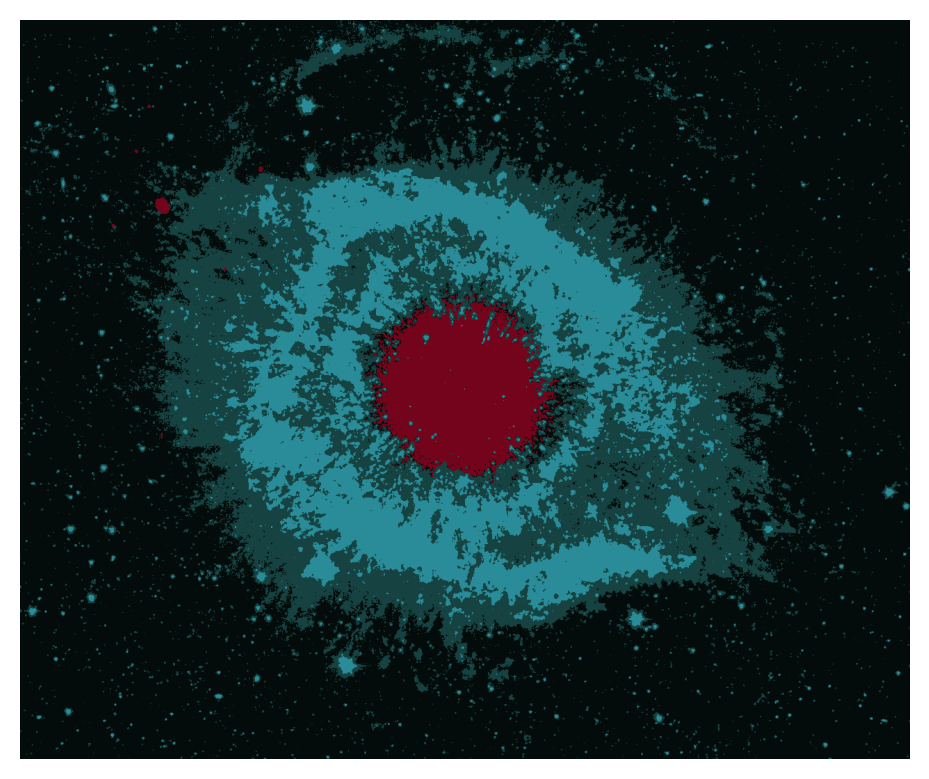

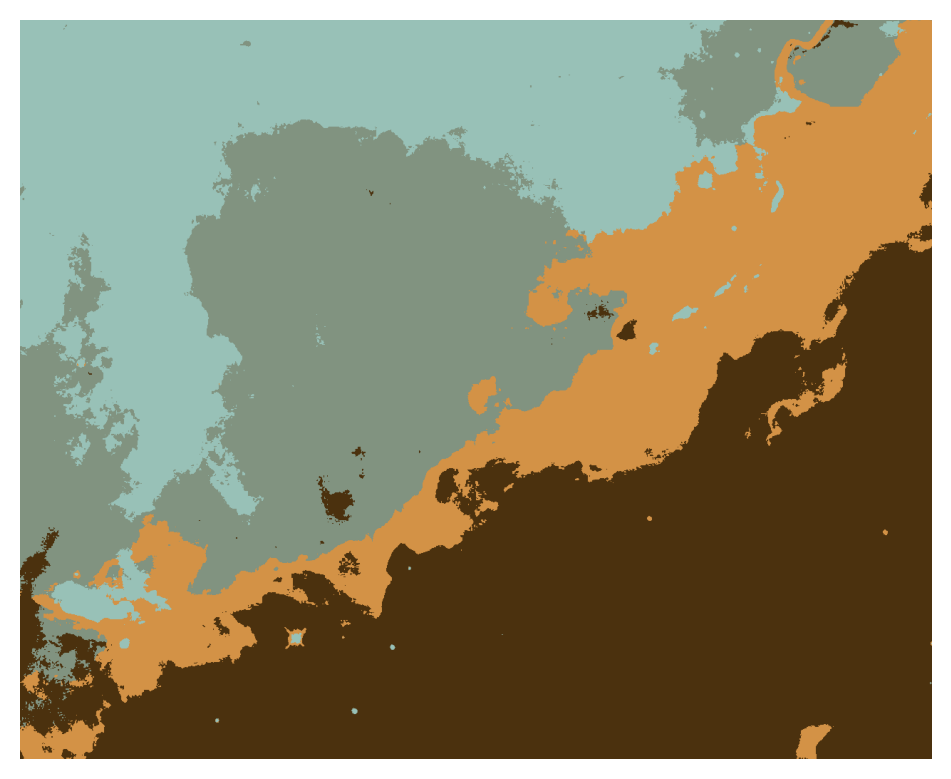

In [29]:
# Testing the quantize_image function with the 6 provided Nasa Images
images = ['./Data/sombrero.jpg', './Data/mystic_mountain.jpg','./Data/crab_nebula.jpg', './Data/cygnus_loop.jpg', './Data/helix_nebula.jpg', './Data/omega_nebula.jpg']
for image in images:
    im = plt.imread(image)
    quantized_im = quantize_image(im, n_clusters=4, n_samples=50)
    plt.imshow(quantized_im)
    plt.axis('off')
    plt.show()